# Spatial Joins

The notebooks on [Spatial Relations](), [Spatial Operations]() and [Voronoi]() showed how we can use the [Shapely]() and [PySAL]() packages to analyse and create geometric features in space. But what about if we want to also analyse data associated with those geometric features?

For example, the `Cholera_Deaths.shp` shapefile [contains](https://github.com/jamesdamillington/john-snow/blob/main/README.md) the number of deaths due to Cholera reported at locations around Soho during the [1854 cholera outbreak](https://en.wikipedia.org/wiki/1854_Broad_Street_cholera_outbreak). How can we compare the number of deaths reported by this datafile to the buffers and Thiessen polygons (voronoi) created in those other notebooks?

To do this we need to do a [`spatial join`](http://wiki.gis.com/wiki/index.php/Spatial_Join) between the deaths point data and the buffer/voronoi polygon data. A spatial join allows us to get attribute data from one spatial layer and transfer it to another layer based on their spatial relationship. We can do this using [functionality in GeoPandas](https://geopandas.org/mergingdata.html#spatial-joins) (which in turn draws on Shapely).   

## Setup

Import required libraries

In [1]:
import geopandas as gpd
import shapely

import matplotlib.pyplot as plt
import matplotlib as mpl   #for colour palette
  
from libpysal.cg import voronoi, voronoi_frames
import numpy as np
import pandas as pd 

Load data

In [2]:
pumps = gpd.read_file('../../data/csds/snow7/pumps.shp')      #point locations of pumps
blocks = gpd.read_file('../../data/dani/polys.shp')           #polygons delineating blocks of buildings
deaths = gpd.read_file('../../data/dani/Cholera_Deaths.shp')  #locations with at least one death (incl death count)

In [3]:
deaths.head()

,Id,Count,geometry
0,0,3,POINT (529308.741 181031.352)
1,0,2,POINT (529312.164 181025.172)
2,0,1,POINT (529314.382 181020.294)
3,0,1,POINT (529317.380 181014.259)
4,0,4,POINT (529320.675 181007.872)


In [4]:
deaths.crs

<Projected CRS: EPSG:27700>
Name: OSGB 1936 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: UK - Britain and UKCS 49°46'N to 61°01'N, 7°33'W to 3°33'E
- bounds: (-9.2, 49.75, 2.88, 61.14)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: OSGB 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

<AxesSubplot:>

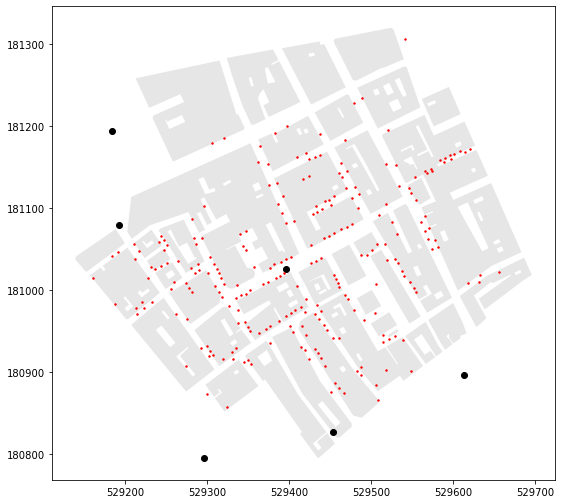

In [5]:
f, ax = plt.subplots(1, figsize=(9, 9))
blocks.plot(ax=ax, facecolor='0.9', linewidth=0)
pumps.plot(ax=ax, color='black')
deaths.plot(ax=ax, color='red', markersize=2)

## Buffers

In [6]:
pumps['buffer']=pumps.buffer(200)

<AxesSubplot:>

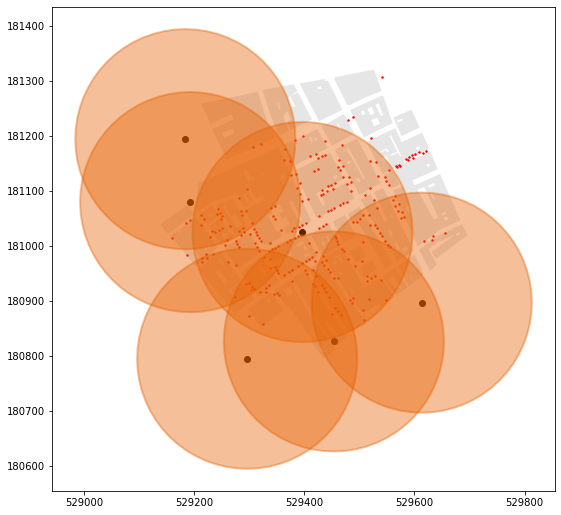

In [7]:
f, ax = plt.subplots(1, figsize=(9, 9))
blocks.plot(ax=ax, facecolor='0.9', linewidth=0)
pumps['geometry'].plot(ax=ax, color='black')
deaths.plot(ax=ax, color='red', markersize=2)
pumps['buffer'].plot(ax=ax, linewidth=2, edgecolor='#e66101', facecolor='#e66101', alpha=0.4)

In [8]:
#pumps has multiple geometries! 
#either do loop for points (deaths) in polygons (buffers)
#or create new df with only buffers (plus names etc), then use spatial join

deaths_in_buffers = gpd.sjoin(pumps, deaths, op='contains', how='inner')
deaths_in_buffers

,ID,x,y,name,geometry,buffer,index_right,Id,Count


In [9]:
buffers = pumps.loc[:, pumps.columns != 'geometry']
buffers

,ID,x,y,name,buffer
0,1,529396.539395,181025.063047,Broad St Pump,"POLYGON ((529596.539 181025.063, 529595.576 18..."
1,2,529192.537868,181079.391380,Great Malborough Pump,"POLYGON ((529392.538 181079.391, 529391.575 18..."
2,3,529183.739766,181193.735013,Ramilies Place Pump,"POLYGON ((529383.740 181193.735, 529382.777 18..."
3,5,529613.205238,180896.804121,Rupert St Pump,"POLYGON ((529813.205 180896.804, 529812.242 18..."
4,6,529453.585995,180826.353152,Brewer St Pump,"POLYGON ((529653.586 180826.353, 529652.623 18..."
5,8,529296.104419,180794.849037,Warwick St Pump,"POLYGON ((529496.104 180794.849, 529495.141 18..."


In [10]:
buffers=buffers.rename(columns = {'buffer':'geometry'})
buffers

,ID,x,y,name,geometry
0,1,529396.539395,181025.063047,Broad St Pump,"POLYGON ((529596.539 181025.063, 529595.576 18..."
1,2,529192.537868,181079.391380,Great Malborough Pump,"POLYGON ((529392.538 181079.391, 529391.575 18..."
2,3,529183.739766,181193.735013,Ramilies Place Pump,"POLYGON ((529383.740 181193.735, 529382.777 18..."
3,5,529613.205238,180896.804121,Rupert St Pump,"POLYGON ((529813.205 180896.804, 529812.242 18..."
4,6,529453.585995,180826.353152,Brewer St Pump,"POLYGON ((529653.586 180826.353, 529652.623 18..."
5,8,529296.104419,180794.849037,Warwick St Pump,"POLYGON ((529496.104 180794.849, 529495.141 18..."


In [11]:
deaths_in_buffers = gpd.sjoin(buffers, deaths, op='contains', how='right')  #use right to get (point) geometry (from deaths)
deaths_in_buffers

,index_left,ID,x,y,name,Id,Count,geometry
0,0.0,1.0,529396.539395,181025.063047,Broad St Pump,0,3,POINT (529308.741 181031.352)
0,1.0,2.0,529192.537868,181079.391380,Great Malborough Pump,0,3,POINT (529308.741 181031.352)
1,0.0,1.0,529396.539395,181025.063047,Broad St Pump,0,2,POINT (529312.164 181025.172)
1,1.0,2.0,529192.537868,181079.391380,Great Malborough Pump,0,2,POINT (529312.164 181025.172)
2,0.0,1.0,529396.539395,181025.063047,Broad St Pump,0,1,POINT (529314.382 181020.294)
...,...,...,...,...,...,...,...,...
248,4.0,6.0,529453.585995,180826.353152,Brewer St Pump,0,1,POINT (529299.361 180873.185)
248,5.0,8.0,529296.104419,180794.849037,Warwick St Pump,0,1,POINT (529299.361 180873.185)
249,0.0,1.0,529396.539395,181025.063047,Broad St Pump,0,1,POINT (529324.815 180857.949)
249,4.0,6.0,529453.585995,180826.353152,Brewer St Pump,0,1,POINT (529324.815 180857.949)


In [12]:
deaths.shape

(250, 3)

<AxesSubplot:>

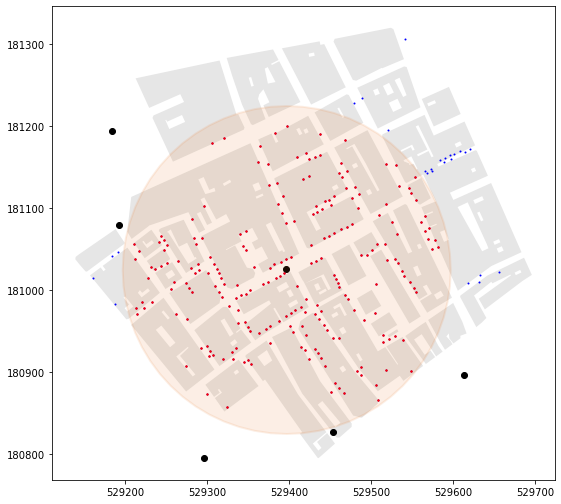

In [13]:
f, ax = plt.subplots(1, figsize=(9, 9))
blocks.plot(ax=ax, facecolor='0.9', linewidth=0)
pumps.plot(ax=ax, color='black')
buffers[buffers['name']=='Broad St Pump'].plot(ax=ax, linewidth=2, 
                                               edgecolor='#e66101', facecolor='#e66101', alpha=0.1)
deaths.plot(ax=ax, color='blue', markersize=1)
deaths_in_buffers[deaths_in_buffers['name']=='Broad St Pump'].plot(ax=ax, color='red', markersize=2)

<AxesSubplot:>

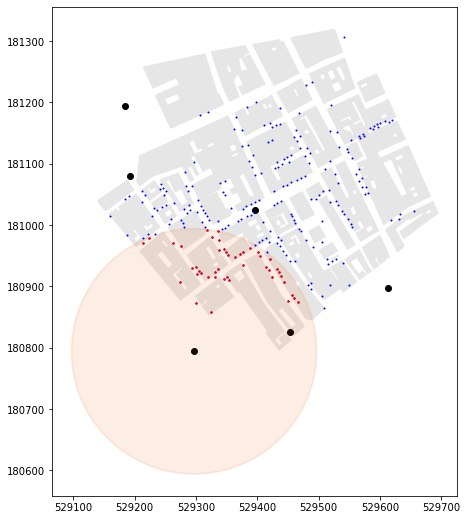

In [14]:
f, ax = plt.subplots(1, figsize=(9, 9))
blocks.plot(ax=ax, facecolor='0.9', linewidth=0)
pumps.plot(ax=ax, color='black')
buffers[buffers['name']=='Warwick St Pump'].plot(ax=ax, linewidth=2, 
                                               edgecolor='#e66101', facecolor='#e66101', alpha=0.1)
deaths.plot(ax=ax, color='blue', markersize=1)
deaths_in_buffers[deaths_in_buffers['name']=='Warwick St Pump'].plot(ax=ax, color='red', markersize=2)

In [15]:
deaths_in_buffers["name"].value_counts()

Broad St Pump            225
Great Malborough Pump     82
Brewer St Pump            80
Rupert St Pump            66
Warwick St Pump           46
Ramilies Place Pump       32
Name: name, dtype: int64

<AxesSubplot:>

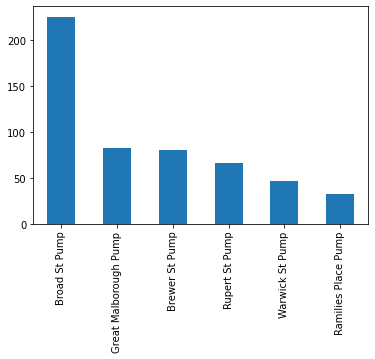

In [16]:
deaths_in_buffers["name"].value_counts().plot.bar()

## Voronoi

In [17]:
points = np.vstack([pumps['x'], pumps['y']]).T  
regions_df, vertices_df = voronoi_frames(points, clip='none')

In [18]:
regions_df['name'] = pumps['name']
vertices_df['name'] = pumps['name']
regions_df

,geometry,name
0,"POLYGON ((529355.796 180905.823, 529265.984 18...",Broad St Pump
1,"POLYGON ((-126296.896 -57664.076, 529265.984 1...",Great Malborough Pump
2,"POLYGON ((-166260.985 127625.654, 529319.694 1...",Ramilies Place Pump
3,"POLYGON ((811193.117 -457288.785, 927233.697 7...",Rupert St Pump
4,"POLYGON ((666206.189 -503176.740, 811193.117 -...",Brewer St Pump
5,"POLYGON ((-126296.896 -57664.076, 666206.189 -...",Warwick St Pump


<AxesSubplot:>

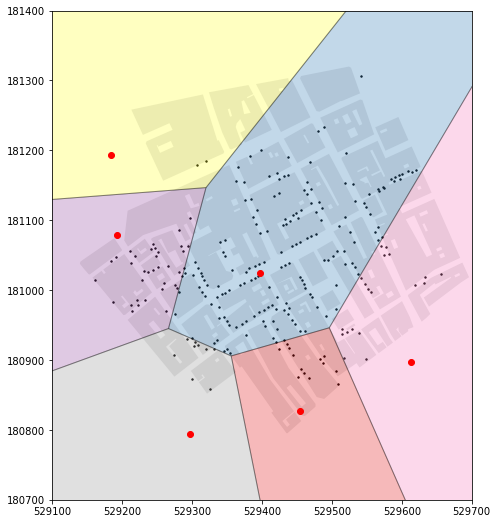

In [19]:
f, ax = plt.subplots(1, figsize=(9, 9))
ax.set_xlim(529100,529700)   #play with these values
ax.set_ylim(180700,181400)   #play with these values
blocks.plot(ax=ax, facecolor='0.9', linewidth=0)
deaths.plot(ax=ax, facecolor='black', markersize=2)
#use column here with a colourmap 
regions_df.plot(ax=ax, column='name', cmap='Set1', edgecolor='black', alpha=0.3)
vertices_df.plot(ax=ax, color='red')

In [20]:
deaths_in_voronoi = gpd.sjoin(regions_df, deaths, op='contains', how='right')

/home/james/anaconda3/envs/sds2020/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:27700

  """Entry point for launching an IPython kernel.


In [21]:
regions_df.crs

In [22]:
print(regions_df.crs)

None


In [23]:
deaths.crs

<Projected CRS: EPSG:27700>
Name: OSGB 1936 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: UK - Britain and UKCS 49°46'N to 61°01'N, 7°33'W to 3°33'E
- bounds: (-9.2, 49.75, 2.88, 61.14)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: OSGB 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

In [24]:
regions_df= regions_df.set_crs(epsg=27700)

In [27]:
print(regions_df.crs)

epsg:27700


In [28]:
deaths_in_voronoi = gpd.sjoin(regions_df, deaths, op='contains', how='right')
deaths_in_voronoi

,index_left,name,Id,Count,geometry
0,0,Broad St Pump,0,3,POINT (529308.741 181031.352)
1,0,Broad St Pump,0,2,POINT (529312.164 181025.172)
2,0,Broad St Pump,0,1,POINT (529314.382 181020.294)
3,0,Broad St Pump,0,1,POINT (529317.380 181014.259)
4,0,Broad St Pump,0,4,POINT (529320.675 181007.872)
...,...,...,...,...,...
245,0,Broad St Pump,0,3,POINT (529362.665 181156.058)
246,0,Broad St Pump,0,2,POINT (529365.152 181176.129)
247,5,Warwick St Pump,0,1,POINT (529274.165 180907.313)
248,5,Warwick St Pump,0,1,POINT (529299.361 180873.185)


In [29]:
deaths.shape

(250, 3)

(180700.0, 181400.0)

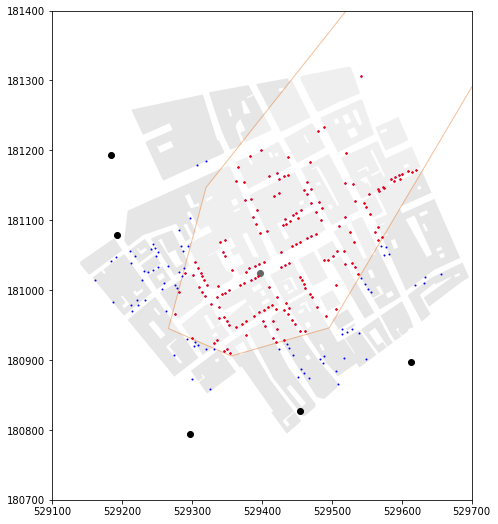

In [30]:
f, ax = plt.subplots(1, figsize=(9, 9))
blocks.plot(ax=ax, facecolor='0.9', linewidth=0)
pumps.plot(ax=ax, color='black')
regions_df[regions_df['name']=='Broad St Pump'].plot(ax=ax, linewidth=1, 
                                               edgecolor='#e66101', facecolor='white', alpha=0.4)
deaths.plot(ax=ax, color='blue', markersize=1)
deaths_in_voronoi[deaths_in_voronoi['name']=='Broad St Pump'].plot(ax=ax, color='red', markersize=2)

ax.set_xlim(529100,529700)   #play with these values
ax.set_ylim(180700,181400)   #play with these values

In [31]:
list(deaths_in_voronoi['name'].unique())

['Broad St Pump',
 'Great Malborough Pump',
 'Warwick St Pump',
 'Brewer St Pump',
 'Rupert St Pump',
 'Ramilies Place Pump']

(180700.0, 181400.0)

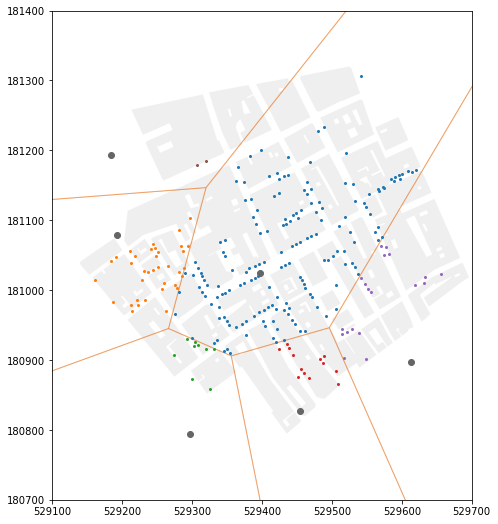

In [32]:
f, ax = plt.subplots(1, figsize=(9, 9))
blocks.plot(ax=ax, facecolor='0.9', linewidth=0)
pumps.plot(ax=ax, color='black')

regions_df.plot(ax=ax, linewidth=1, edgecolor='#e66101', facecolor='white', alpha=0.4)

for idx, name in enumerate(list(deaths_in_voronoi['name'].unique())):
    deaths_in_voronoi[deaths_in_voronoi['name']==name].plot(ax=ax,color=mpl.cm.tab10(idx), markersize=4)

ax.set_xlim(529100,529700)   #play with these values
ax.set_ylim(180700,181400)   #play with these values

In [33]:
deaths_in_voronoi["name"].value_counts()

Broad St Pump            171
Great Malborough Pump     36
Rupert St Pump            19
Brewer St Pump            13
Warwick St Pump            9
Ramilies Place Pump        2
Name: name, dtype: int64

<AxesSubplot:>

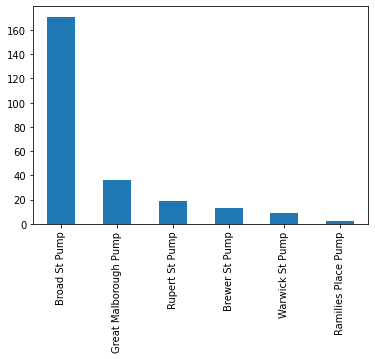

In [34]:
deaths_in_voronoi["name"].value_counts().plot.bar()

## Comparison

In [43]:
vcounts = deaths_in_voronoi["name"].value_counts()
bcounts = deaths_in_buffers["name"].value_counts()
compare = pd.merge(bcounts, vcounts, right_index = True,left_index = True)

In [44]:
compare

,name_x,name_y
Broad St Pump,225,171
Great Malborough Pump,82,36
Brewer St Pump,80,13
Rupert St Pump,66,19
Warwick St Pump,46,9
Ramilies Place Pump,32,2


In [37]:
compare = compare.rename(columns={
    'name_x':'buffers',
    'name_y':'voronoi'})
compare

,buffers,voronoi
Broad St Pump,225,171
Great Malborough Pump,82,36
Brewer St Pump,80,13
Rupert St Pump,66,19
Warwick St Pump,46,9
Ramilies Place Pump,32,2


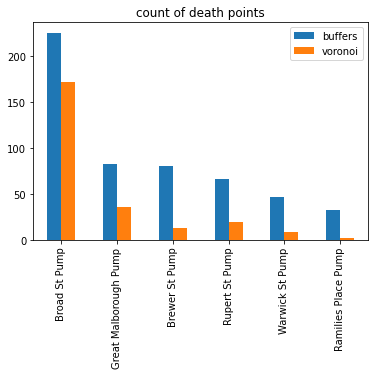

In [38]:
compare.sort_values('buffers',ascending=False).plot.bar(title="count of death points")
plt.show()

Cholera Deaths point data [are](https://bitbucket.org/darribas/reproducible_john_snow/src/master/data/README.txt):
>Points for each location of one or more deaths. Attribute value gives number of deaths at that location

In [39]:
vdeaths = deaths_in_voronoi.groupby('name')['Count'].sum()
bdeaths = deaths_in_buffers.groupby('name')['Count'].sum()
compareSums = pd.merge(bdeaths,vdeaths,right_index = True,left_index = True)
compareSums = compareSums.rename(columns={
    'Count_x':'buffers',
    'Count_y':'voronoi'})
compareSums

,buffers,voronoi
name,,
Brewer St Pump,149,27
Broad St Pump,451,340
Great Malborough Pump,159,65
Ramilies Place Pump,61,5
Rupert St Pump,134,40
Warwick St Pump,74,12


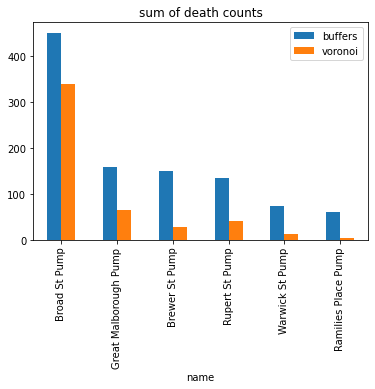

In [40]:
compareSums.sort_values('buffers',ascending=False).plot.bar(title="sum of death counts")
plt.show()

In [41]:
deaths['Count'].sum()

489

In [42]:
compareSums.sum()

buffers    1028
voronoi     489
dtype: int64

## Further Reading

https://kodu.ut.ee/~kmoch/geopython2018/lessons/L3/spatial-join.html

## Credits!

### Contributors:
The following individual(s) have contributed to these teaching materials: James Millington (james.millington@kcl.ac.uk).

### License
These teaching materials are licensed under a mix of [The MIT License](https://opensource.org/licenses/mit-license.php) and the [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 license](https://creativecommons.org/licenses/by-nc-sa/4.0/).